In [1]:
import re
import numpy as np
import pandas as pd
# plotting
import seaborn as sns
from wordcloud import WordCloud
import matplotlib.pyplot as plt
# nltk
from nltk.stem import WordNetLemmatizer
import nltk

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
# sklearn
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.ensemble import RandomForestClassifier

In [2]:
pip install wordcloud

Note: you may need to restart the kernel to use updated packages.


## Loading a Dataset

In [3]:
# Importing the dataset
DATASET_COLUMNS=['target','ids','date','flag','user','text']
DATASET_ENCODING = "ISO-8859-1"
df_twitter = pd.read_csv('twitter.csv', encoding=DATASET_ENCODING, names=DATASET_COLUMNS)
df_twitter.sample(5)

,target,ids,date,flag,user,text
1015598,4,1881581771,Fri May 22 05:02:45 PDT 2009,NO_QUERY,beartwinsmom,@juliahome4 Thank you for the #followfriday lo...
902580,4,1694455962,Mon May 04 02:42:36 PDT 2009,NO_QUERY,jdrydenUK,@theiBlog Haha I like that. You're actually sa...
1472027,4,2065314492,Sun Jun 07 08:20:28 PDT 2009,NO_QUERY,patriciaco,@jaaaaayehm I hope I have a lot of Two Three c...
145954,0,1882351422,Fri May 22 06:42:52 PDT 2009,NO_QUERY,Amaren88,"@TomFelton What? Chocolate?? I want chocolate,..."
180170,0,1966484624,Fri May 29 17:51:11 PDT 2009,NO_QUERY,NailaFarhana,I so need gilmore girls season 5


In [4]:
df_twitter.shape

(1600000, 6)

Datasets consists of 1600000 rows and 6 columns. 

In [5]:
df_twitter.dtypes

target     int64
ids        int64
date      object
flag      object
user      object
text      object
dtype: object

In [6]:
df_twitter.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 6 columns):
 #   Column  Non-Null Count    Dtype 
---  ------  --------------    ----- 
 0   target  1600000 non-null  int64 
 1   ids     1600000 non-null  int64 
 2   date    1600000 non-null  object
 3   flag    1600000 non-null  object
 4   user    1600000 non-null  object
 5   text    1600000 non-null  object
dtypes: int64(2), object(4)
memory usage: 73.2+ MB


## EDA 

In [7]:
df_twitter.isnull().sum()

target    0
ids       0
date      0
flag      0
user      0
text      0
dtype: int64

There are no null values present in the dataframe.

In [8]:
# Defining a new dataframe
df_twitt = df_twitter[['target','text']]

In [9]:
df_twitt['target'].nunique()

2

Target columns has only two value i.e negative and positive

In [10]:
df_twitt['target'].unique()

array([0, 4], dtype=int64)

In [11]:
df_twitt['target'].value_counts()

0    800000
4    800000
Name: target, dtype: int64

Data is balanced.

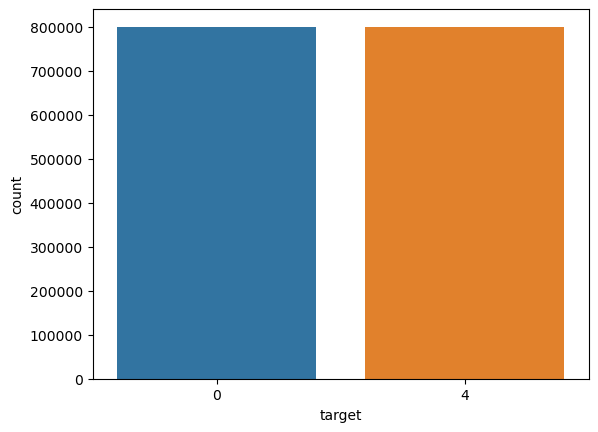

In [12]:
sns.countplot(x=df_twitt['target'],data=df_twitt)
plt.show()

In [13]:
df_twitter['target'].replace(4,1,inplace=True)
df_twitt['target'].replace(4,1,inplace=True)

C:\Users\Shekhar Singh\AppData\Local\Temp\ipykernel_2440\2878525725.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_twitt['target'].replace(4,1,inplace=True)


In [14]:
df_twitt.head()

,target,text
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."


In [15]:
def word_count(words):
    return len(words.split())

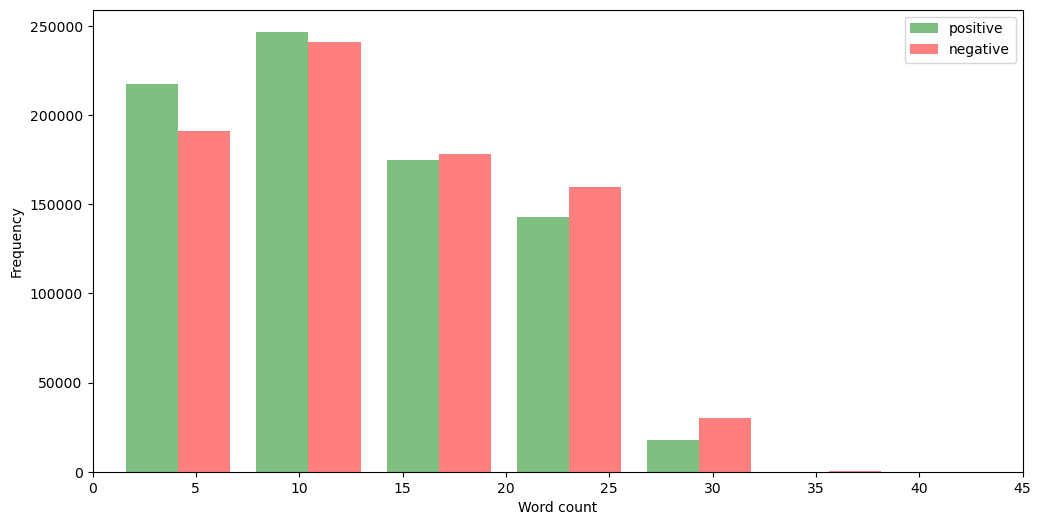

In [16]:
#distribution of words in sentence
df_twitter['word count'] = df_twitter['text'].apply(word_count)
p = df_twitter['word count'][df_twitter.target == 1]
n = df_twitter['word count'][df_twitter.target == 0]
plt.figure(figsize=(12,6))
plt.xlim(0,45)
plt.xlabel('Word count')
plt.ylabel('Frequency')
g = plt.hist([p, n], color=['g','r'], alpha=0.5, label=['positive','negative'])
plt.legend(loc='upper right')
plt.show()

In [17]:
df_twitt['text'] = df_twitt['text'].astype('str')

C:\Users\Shekhar Singh\AppData\Local\Temp\ipykernel_2440\1275919504.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_twitt['text'] = df_twitt['text'].astype('str')


## Data Preprocessing

In [18]:
nltk.download('stopwords')
stopword = set(stopwords.words('english'))
print(stopword)

{'in', 'when', "won't", 'so', 'its', 'don', 'that', 'there', 's', "mightn't", 'itself', 'over', 'not', 'some', 'hasn', 'his', 'her', "couldn't", 'the', "you'll", 'again', 'up', 'only', 'about', 'an', 'being', 'shouldn', 'is', 're', "haven't", 'once', "hadn't", 'whom', 'herself', 'wouldn', 'between', 'no', 'we', 'your', 'my', 'does', "hasn't", 'had', 'most', 'very', 'himself', 'this', 'out', 'be', 'to', 'ours', 'where', 'than', 'under', 'aren', 'having', "you're", "needn't", 'haven', 'further', 'myself', 'on', "it's", "doesn't", 'mightn', 'each', "wouldn't", 'down', "should've", "weren't", 'just', 'while', 'through', 'any', 'mustn', 'he', 'other', 've', 'y', 'll', 'and', 'during', 'our', 'their', 'nor', "you've", 'ain', 'have', 'him', 'after', 'such', 'at', 'what', 'yourself', 'why', "that'll", 'own', 'themselves', 'are', "mustn't", 'you', 'ma', 'more', 'against', 'doing', "isn't", 'or', 'did', 'will', 'am', "she's", 'with', 'how', 'above', 'a', 'because', 'theirs', 'can', 'she', 'those

[nltk_data] Downloading package stopwords to C:\Users\Shekhar
[nltk_data]     Singh\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [19]:
import string
english_punctuations = string.punctuation
punctuations_list = english_punctuations

In [20]:
urlPattern = r"((http://)[^ ]*|(https://)[^ ]*|( www\.)[^ ]*)"
userPattern = '@[^\s]+'
def process_tweets(tweet):
  # Lower Casing
    tweet = tweet.lower()
    tweet=tweet[1:]
    # Removing all URls 
    tweet = re.sub(urlPattern,'',tweet)
    # Removing all @username.
    tweet = re.sub(userPattern,'', tweet) 
    #Remove punctuations
    tweet = tweet.translate(str.maketrans("","",string.punctuation))
    #tokenizing words
    tokens = word_tokenize(tweet)
    #Removing Stop Words
    final_tokens = [w for w in tokens if w not in stopword]
    #reducing a word to its word stem 
    wordLemm = WordNetLemmatizer()
    finalwords=[]
    for w in final_tokens:
      if len(w)>1:
        word = wordLemm.lemmatize(w)
        finalwords.append(word)
    return ' '.join(finalwords)

In [21]:
df_twitt['text'] = df_twitt['text'].apply(lambda x: process_tweets(x))
print('Text Preprocessing complete.')
df_twitt.head()

Text Preprocessing complete.


C:\Users\Shekhar Singh\AppData\Local\Temp\ipykernel_2440\2540953249.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_twitt['text'] = df_twitt['text'].apply(lambda x: process_tweets(x))


,target,text
0,0,switchfoot awww thats bummer shoulda got david...
1,0,upset cant update facebook texting might cry r...
2,0,kenichan dived many time ball managed save 50 ...
3,0,whole body feel itchy like fire
4,0,nationwideclass behaving im mad cant see


In [22]:
X=df_twitt.text
y=df_twitt.target

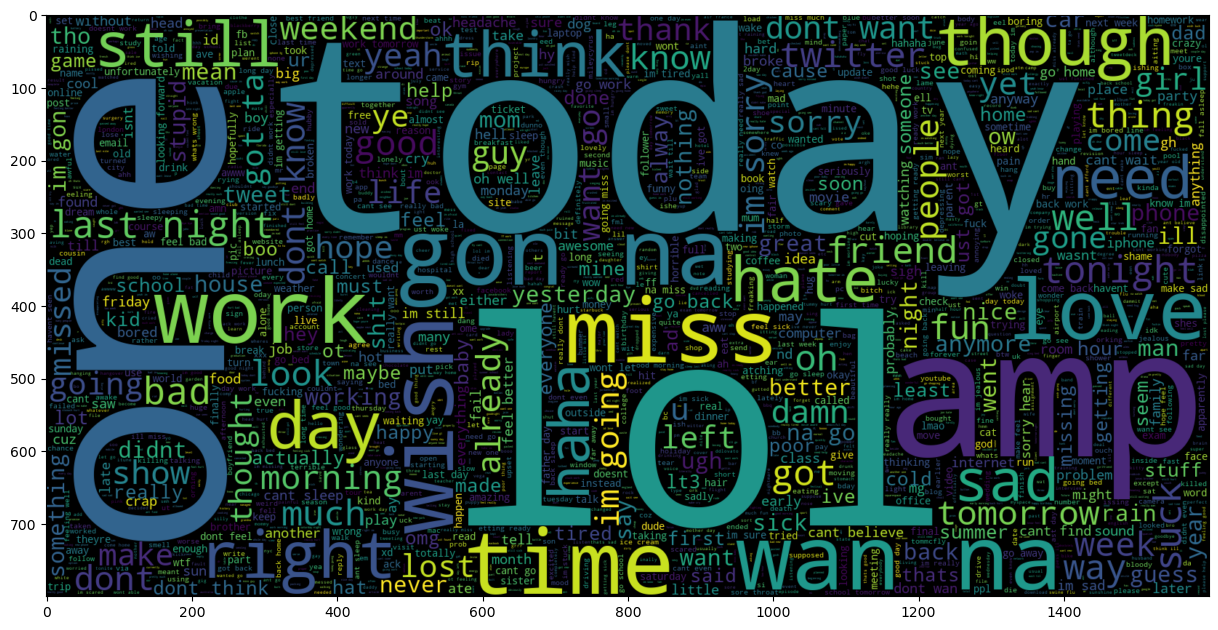

In [23]:
plt.figure(figsize = (15,15)) 
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800).generate(" ".join(df_twitt[df_twitt.target == 0].text))
plt.imshow(wc , interpolation = 'bilinear')

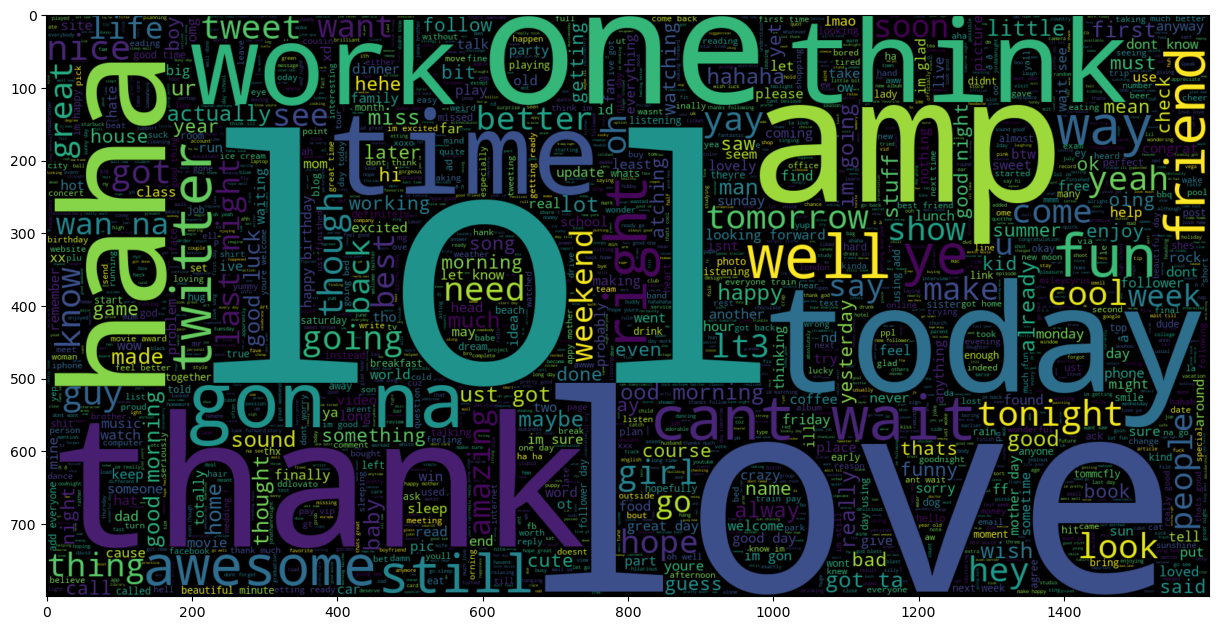

In [24]:
plt.figure(figsize = (15,15)) 
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800).generate(" ".join(df_twitt[df_twitt.target == 1].text))
plt.imshow(wc , interpolation = 'bilinear')

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.10, random_state =100)

In [26]:
vectoriser = TfidfVectorizer(ngram_range=(1,2), max_features=500000)
vectoriser.fit(X_train)
print('No. of feature_words: ', len(vectoriser.get_feature_names()))

C:\Users\Shekhar Singh\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


No. of feature_words:  500000


In [27]:
X_train = vectoriser.transform(X_train)
X_test  = vectoriser.transform(X_test)


In [28]:
def model_Evaluate(model):
# Predict values for Test dataset
    y_pred = model.predict(X_test)
    # Print the evaluation metrics for the dataset.
    print(classification_report(y_test, y_pred))
    # Compute and plot the Confusion matrix
    cf_matrix = confusion_matrix(y_test, y_pred)
    categories = ['Negative','Positive']
    group_names = ['True Neg','False Pos', 'False Neg','True Pos']
    group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]
    labels = [f'{v1}n{v2}' for v1, v2 in zip(group_names,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(cf_matrix, annot = labels, cmap = 'Blues',fmt = '',
    xticklabels = categories, yticklabels = categories)
    plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
    plt.ylabel("Actual values" , fontdict = {'size':14}, labelpad = 10)
    plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)

              precision    recall  f1-score   support

           0       0.80      0.76      0.78     80277
           1       0.77      0.81      0.79     79723

    accuracy                           0.79    160000
   macro avg       0.79      0.79      0.78    160000
weighted avg       0.79      0.79      0.78    160000



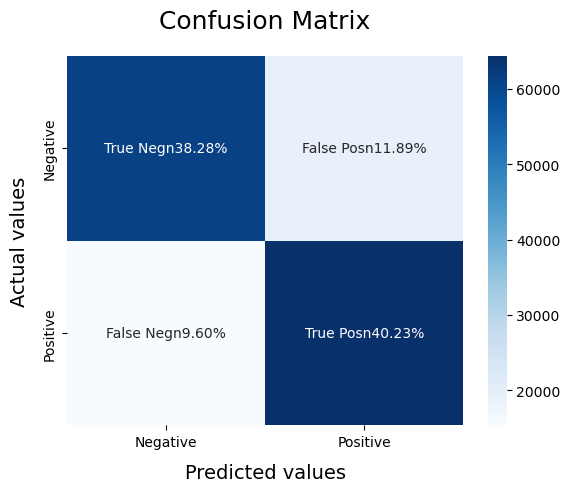

In [29]:
BNBmodel = BernoulliNB()
BNBmodel.fit(X_train, y_train)
model_Evaluate(BNBmodel)
y_pred1 = BNBmodel.predict(X_test)


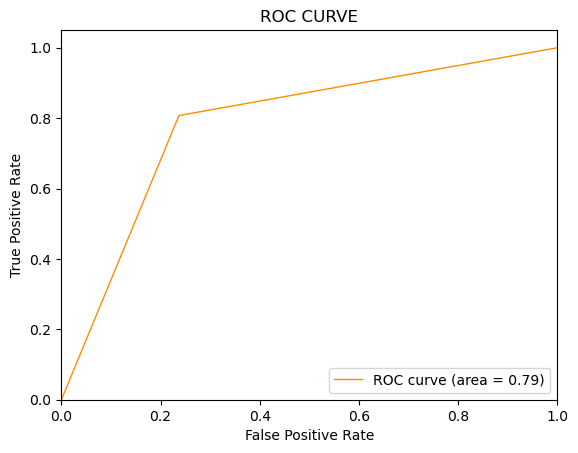

In [30]:
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(y_test, y_pred1)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC CURVE')
plt.legend(loc="lower right")
plt.show()

              precision    recall  f1-score   support

           0       0.79      0.78      0.78     80277
           1       0.78      0.80      0.79     79723

    accuracy                           0.79    160000
   macro avg       0.79      0.79      0.79    160000
weighted avg       0.79      0.79      0.79    160000



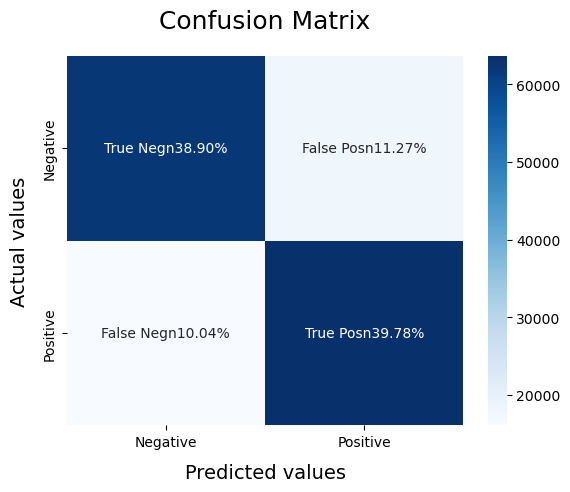

In [31]:
SVCmodel = LinearSVC()
SVCmodel.fit(X_train, y_train)
model_Evaluate(SVCmodel)
y_pred2 = SVCmodel.predict(X_test)

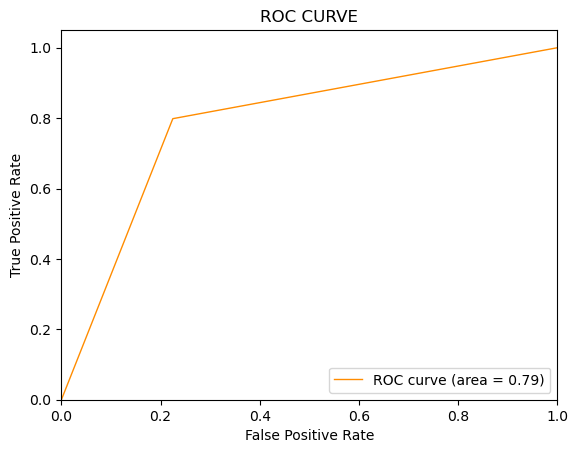

In [32]:
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(y_test, y_pred2)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC CURVE')
plt.legend(loc="lower right")
plt.show()

              precision    recall  f1-score   support

           0       0.81      0.79      0.80     80277
           1       0.79      0.82      0.80     79723

    accuracy                           0.80    160000
   macro avg       0.80      0.80      0.80    160000
weighted avg       0.80      0.80      0.80    160000



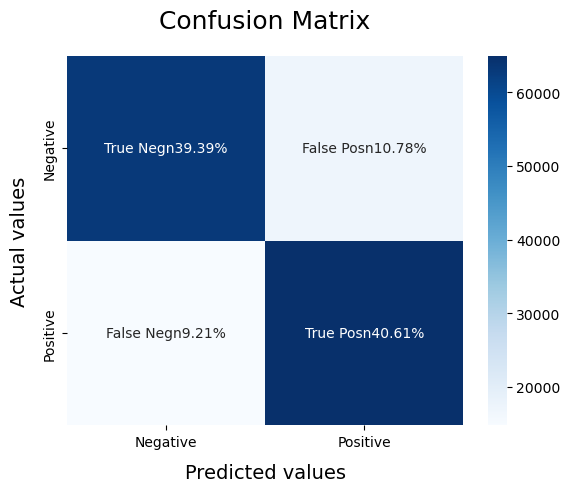

In [33]:
LRmodel = LogisticRegression(C = 2, max_iter = 1000, n_jobs=-1)
LRmodel.fit(X_train, y_train)
model_Evaluate(LRmodel)
y_pred3 = LRmodel.predict(X_test)

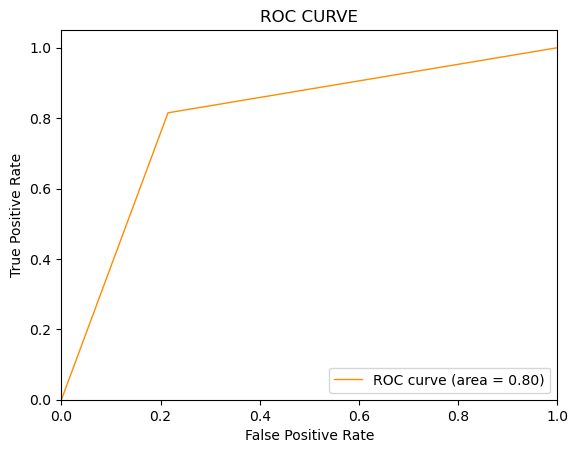

In [34]:
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(y_test, y_pred3)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC CURVE')
plt.legend(loc="lower right")
plt.show()

              precision    recall  f1-score   support

           0       0.75      0.61      0.67     80277
           1       0.67      0.80      0.73     79723

    accuracy                           0.70    160000
   macro avg       0.71      0.70      0.70    160000
weighted avg       0.71      0.70      0.70    160000



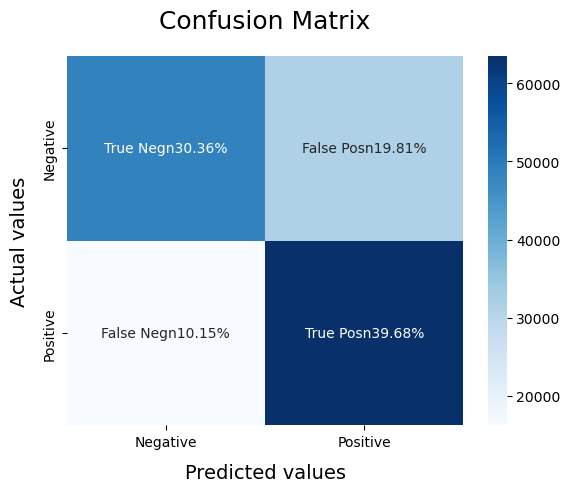

In [35]:

rf = RandomForestClassifier(n_estimators = 20, criterion = 'entropy', max_depth=50)
rf.fit(X_train, y_train)
model_Evaluate(rf)

In [36]:
import tensorflow as tf
import keras

print(tf.__version__)
print(keras.__version__)

2.9.1
2.9.0


In [37]:
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, Dropout
from sklearn.feature_extraction.text import CountVectorizer
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences
from keras.utils.np_utils import to_categorical
import re

In [38]:
from keras.preprocessing.text import Tokenizer

from keras import regularizers

max_words = 5000
max_len = 200

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(df_twitt.text)
sequences = tokenizer.texts_to_sequences(df_twitt.text)
tweets = pad_sequences(sequences, maxlen=max_len)
print(tweets)

[[   0    0    0 ...  759 1865    2]
 [   0    0    0 ...   11  187 1283]
 [   0    0    0 ...  368    6 3132]
 ...
 [   0    0    0 ...  123  504 1746]
 [   0    0    0 ...  415 4997   12]
 [   0    0    0 ...    0    0  458]]


In [39]:
X_train, X_test, y_train, y_test = train_test_split(tweets, df_twitt.target.values, test_size=0.2, random_state=101)

In [41]:
from keras.models import Sequential
from keras import layers
from keras import regularizers
from keras import backend as K
from keras.callbacks import ModelCheckpoint
model2 = Sequential()
model2.add(layers.Embedding(max_words, 128))
model2.add(layers.LSTM(64,dropout=0.5))
model2.add(layers.Dense(16, activation='relu'))
model2.add(layers.Dense(8, activation='relu'))
model2.add(layers.Dense(1,activation='sigmoid'))
model2.compile(optimizer='adam',loss='binary_crossentropy', metrics=['accuracy'])
checkpoint2 = ModelCheckpoint("rnn_model.hdf5", monitor='val_accuracy', verbose=1,save_best_only=True, mode='auto', period=1,save_weights_only=False)
history = model2.fit(X_train, y_train, epochs=1,validation_data=(X_test, y_test),callbacks=[checkpoint2])

40000/40000 [==============================] - ETA: 0s - loss: 0.4724 - accuracy: 0.7728
Epoch 1: val_accuracy improved from -inf to 0.78243, saving model to rnn_model.hdf5
40000/40000 [==============================] - 3739s 93ms/step - loss: 0.4724 - accuracy: 0.7728 - val_loss: 0.4553 - val_accuracy: 0.7824


In [42]:
sequence = tokenizer.texts_to_sequences(['this data science course is best ever'])
test = pad_sequences(sequence, maxlen=max_len)
pred = model2.predict(test)
if pred > 0.5:
  print('Positive')
else:
  print('Negative')

1/1 [==============================] - 0s 489ms/step
Positive


In [45]:
sequence = tokenizer.texts_to_sequences(['this data science course is bad one'])
test = pad_sequences(sequence, maxlen=max_len)
pred = model2.predict(test)
if pred > 0.5:
  print('Positive')
else:
  print('Negative')

1/1 [==============================] - 0s 28ms/step
Negative
